In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
base_dir = 'E:/Files/Document/ngoding ngab/Portofolio/2. Gemastik 2023/dataset/fix/indeks-standar-pencemar-udara-di-provinsi-dki-jakarta.csv'
df = pd.read_csv(base_dir, index_col=0, parse_dates=True)
df.head()

,pm10,so2,co,o3,no2,max,critical,categori,lokasi_spku
tanggal,,,,,,,,,
2018-01-01,76.0,31.0,38.0,35.0,9.0,76.0,PM10,SEDANG,DKI4
2018-01-02,23.0,31.0,24.0,39.0,14.0,39.0,O3,BAIK,DKI3
2018-01-03,53.0,35.0,35.0,101.0,23.0,101.0,O3,TIDAK SEHAT,DKI3
2018-01-04,53.0,49.0,34.0,57.0,15.0,57.0,O3,SEDANG,DKI3
2018-01-05,44.0,32.0,26.0,28.0,10.0,44.0,PM10,BAIK,DKI4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 923 entries, 2018-01-01 to 2020-07-31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm10         923 non-null    float64
 1   so2          923 non-null    float64
 2   co           923 non-null    float64
 3   o3           923 non-null    float64
 4   no2          923 non-null    float64
 5   max          923 non-null    float64
 6   critical     895 non-null    object 
 7   categori     892 non-null    object 
 8   lokasi_spku  892 non-null    object 
dtypes: float64(6), object(3)
memory usage: 72.1+ KB


In [4]:
df.isnull().sum()

pm10            0
so2             0
co              0
o3              0
no2             0
max             0
critical       28
categori       31
lokasi_spku    31
dtype: int64

## Data Preparation

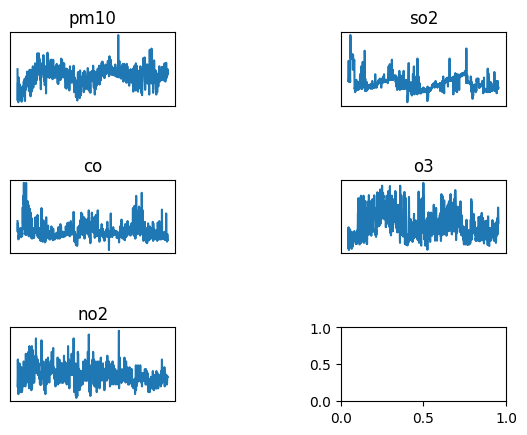

In [5]:
# previewing the features data
groups = [0, 1, 2, 3, 4]
values = df.values
fig, sub = plt.subplots(3, 2)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(), groups):
    ax.plot(values[:, i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(df.columns[i])

plt.show()

In [6]:
scaler = MinMaxScaler()
num_values = [0, 1, 2, 3, 4] 
scaled = scaler.fit_transform(df.values[:, num_values])
scaled[0]


array([0.49122807, 0.31666667, 0.43181818, 0.03255814, 0.17142857])

In [7]:
# convert series to supervised learning
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [8]:
time_steps = 2

supervised = to_supervised(scaled, lag=time_steps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.491228,0.316667,0.431818,0.032558,0.171429,0.026316,0.316667,0.272727,0.051163,0.314286,0.289474
1,0.026316,0.316667,0.272727,0.051163,0.314286,0.289474,0.383333,0.397727,0.339535,0.571429,0.289474
2,0.289474,0.383333,0.397727,0.339535,0.571429,0.289474,0.616667,0.386364,0.134884,0.342857,0.210526
3,0.289474,0.616667,0.386364,0.134884,0.342857,0.210526,0.333333,0.295455,0.000000,0.200000,0.000000
4,0.210526,0.333333,0.295455,0.000000,0.200000,0.000000,0.300000,0.250000,0.013953,0.057143,0.052632


In [9]:
# split data into train and test-sets
train_ratio = 0.8
train_size = int(train_ratio * len(supervised))

x_train = supervised[:train_size, :-1]
y_train = supervised[:train_size, -1]

x_test = supervised[train_size:, :-1]
y_test = supervised[train_size:, -1]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((736, 10), (736,), (185, 10), (185,))

In [20]:
features = 5
x_train = x_train.reshape(x_train.shape[0], time_steps, features)
x_test = x_test.reshape(x_test.shape[0], time_steps, features)

x_train.shape, x_test.shape,

((736, 2, 5), (185, 2, 5))

## Build Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, input_shape=(x_train.shape[1], x_train.shape[2])),
    tf.keras.layers.Dense(1)
])

loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 160       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
23/23 [==============================] - 8s 68ms/step - loss: 0.1135 - mae: 0.4544 - val_loss: 0.0963 - val_mae: 0.4209
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0837 - mae: 0.3851 - val_loss: 0.0730 - val_mae: 0.3616
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0613 - mae: 0.3248 - val_loss: 0.0549 - val_mae: 0.3077
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0437 - mae: 0.2695 - val_loss: 0.0401 - val_mae: 0.2567
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0299 - mae: 0.2170 - val_loss: 0.0281 - val_mae: 0.2094
Epoch 6/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0193 - mae: 0.1689 - val_loss: 0.0194 - val_mae: 0.1687
Epoch 7/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0126 - mae: 0.1309 - val_loss: 0.0136 - val_mae: 0.1350
Epoch 8/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0090

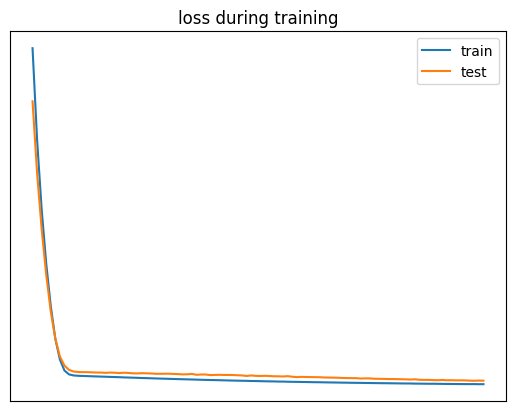

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

## Prediction

In [15]:
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-4:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-4:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

jumlah_hari = y_pred.shape[0]
print("Prediksi untuk", jumlah_hari, "hari.")

6/6 [==============================] - 1s 2ms/step
Prediksi untuk 185 hari.


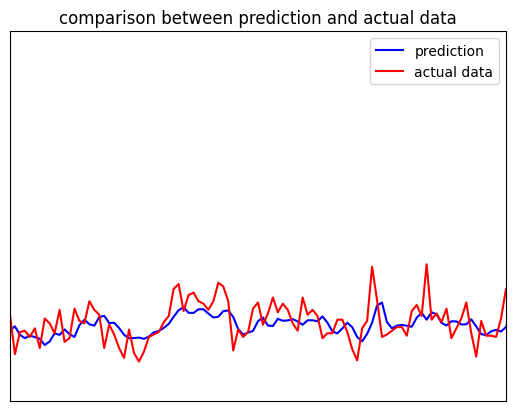

In [16]:
plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

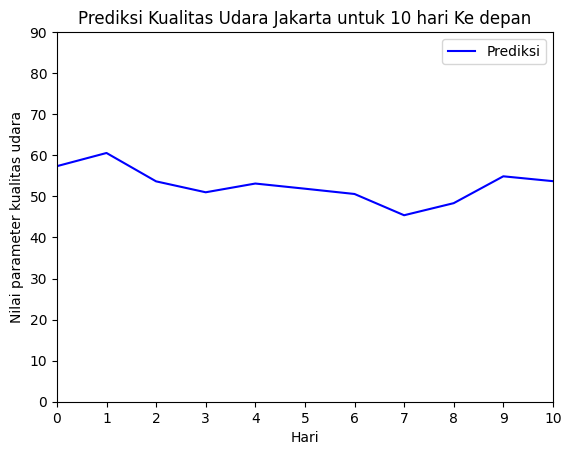

In [17]:
plt.plot(final_pred[:200], label='Prediksi', color='b')
# plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.xticks(range(0, 11, 1))
plt.yticks(range(0, 100, 10))
plt.xlabel('Hari')
plt.ylabel('Nilai parameter kualitas udara')
plt.title('Prediksi Kualitas Udara Jakarta untuk 10 hari Ke depan')
plt.legend()
plt.show()

In [ ]:
# saved model
model.save('model4.h5')

In [21]:
# menghitung nilai rmse menggunakan  model h5
model_h5 = tf.keras.models.load_model('model4.h5')
y_pred_h5 = model_h5.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred_h5, x_test[:,-4:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
final_pred_h5 = inv_new[:,0]

mse_h5 = mean_squared_error(actual_pred, final_pred_h5)
rmse_h5 = np.sqrt(mse_h5)

print("Nilai RMSE: ", rmse_h5)

6/6 [==============================] - 1s 3ms/step
Nilai RMSE:  11.914055145060287
